# World Cities Grouping Based on Places of Interest

Import required libraries.

In [1]:
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim
import folium
import requests
import time
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
import selenium.webdriver
from selenium.webdriver.chrome.options import Options

## 1. Import and pre-process the initial dataset

The collection of cities being used comes from the top 100 cities rank of most visited cities in 2015, as described by Euromonitor International report. The list of pairs cities, country, in the report are available from the `top-visited.csv` file.

We start by reading from both files to two dataframes:

In [2]:
df = pd.read_csv('top-visited.csv')

We inspect the shape of the new dataframe, and the first rows.

In [3]:
print(df.shape)
df.head()

(100, 2)


,City,Country
0,Hong Kong,China
1,Bangkok,Thailand
2,London,UK
3,Singapore,Singapore
4,Paris,France


Now, for each city in the list, retrieve its' latitude and longitude:

In [4]:
latitudes  = []
longitudes = []

geolocator = Nominatim(user_agent='capstone-project-app')

for i, row in df.iterrows():
    location = geolocator.geocode( "{}, {}".format(row['City'], row['Country']) )
    latitudes.append(location[1][0])
    longitudes.append(location[1][1])

And add this new information to the dataframe:

In [5]:
df['Latitude']  = latitudes
df['Longitude'] = longitudes

Inspect the new dataframe shape the first top rows.

In [6]:
print(df.shape)
df.head()

(100, 4)


,City,Country,Latitude,Longitude
0,Hong Kong,China,22.279328,114.162813
1,Bangkok,Thailand,13.753893,100.816080
2,London,UK,51.507322,-0.127647
3,Singapore,Singapore,1.340853,103.878447
4,Paris,France,48.856610,2.351499


Create a world map that contains markers for all the cities in the  dataframe.

In [9]:
# define map center as the latitudes and longitude means
center_lat = df['Latitude'].mean()
center_lon = df['Longitude'].mean()

# create a world map
world_map  = folium.Map(location = [center_lat, center_lon], zoom_start = 1.5)

# add markers from dataframe to map
for i, row in df.iterrows():
    folium.CircleMarker(
        [row['Latitude'], row['Longitude']],
        radius  = 2,
        color   = '#ff9800',
        popup   = folium.Popup(row['City'], parse_html=True),
        tooltip = row['City'],
    ).add_to(world_map)

world_map

We save the HTML map for further use.

In [10]:
world_map.save('world_map.html')

## 2. Retrive information from Foursquare API

Set the requited information to use the Foursquare API.

In [11]:
client_id     = '0W1WEUPV2UDQLU2GF1UGRJNJJTOONGE3XKWK4RNLUODX11VR'
client_secret = 'IMMN0PRL3X4ZXYODZSXPD12OQOGSLZLNN3P25XYB2U4YACTY'
version       = '20180605'

Create a function that given a list of cities, including their latitude and longitude, returns a set of venues of interest centered at the city's coordinates within a radius of 50km.

In [12]:
def getNearbyVenues(names, latitudes, longitudes, limit=100, radius=50000):    
    venues_list = []
    for name, lat, lng in zip(names, latitudes, longitudes):
        time.sleep(0.5)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&limit={}&radius={}'.format(
            client_id, client_secret, version, lat, lng, limit, radius)
        
        # make the GET request
        r = requests.get(url)
        while not r.ok:
            r = requests.get(url)
            
        results = r.json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(name, lat, lng, v['venue']['name'], v['venue']['location']['lat'],
                             v['venue']['location']['lng'], v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 'City Latitude', 'City Longitude',
                             'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
    
    return(nearby_venues)

Create a new dataframe with the venues of interest for every city using the previously defined function.

In [13]:
venues = getNearbyVenues(names = df['City'], latitudes = df['Latitude'], longitudes = df['Longitude'])

We drop the rows (venues) that category matches "City".

In [14]:
venues.drop(venues[venues['Venue Category'] == 'City'].index, inplace=True)

Examine the total number of categories.

In [15]:
print('There are {} unique categories.'.format(len(venues['Venue Category'].unique())))

There are 472 unique categories.


One hot encode the venues' categories in a new dataframe

In [16]:
# one hot encode the venues' categories
onehot = pd.get_dummies(venues[['Venue Category']], prefix = '', prefix_sep = '')

# add city column back to the dataframe
onehot.insert(loc = 0, column = 'City', value = venues['City'])

Inspect the shape and ther first rows of the new dataframe.

In [17]:
print(onehot.shape)
onehot.head()

(9779, 473)


,City,Acai House,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,American Restaurant,Andhra Restaurant,...,Wine Shop,Winery,Women's Store,Yakitori Restaurant,Yoga Studio,Yoshoku Restaurant,Yunnan Restaurant,Zhejiang Restaurant,Zoo,Zoo Exhibit
0,Hong Kong,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,Hong Kong,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Hong Kong,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Hong Kong,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Hong Kong,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now create a new dataframe by grouping rows per city, using the mean.

In [18]:
grouped = onehot.groupby('City').mean().reset_index()

Inspect the shape and ther first rows of the new dataframe.

In [19]:
print(grouped.shape)
grouped.head()

(100, 473)


,City,Acai House,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,American Restaurant,Andhra Restaurant,...,Wine Shop,Winery,Women's Store,Yakitori Restaurant,Yoga Studio,Yoshoku Restaurant,Yunnan Restaurant,Zhejiang Restaurant,Zoo,Zoo Exhibit
0,Agra,0.0,0.0,0.0,0.0,0.0,0.016949,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.0
1,Amsterdam,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.01,0.0,0.02,0.0,0.0,0.0,0.00,0.0
2,Antalya,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.0
3,Athens,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.0
4,Auckland,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.01,0.0


Create a new dataframe from the grouped data for clustering, simply drop the city name column.

In [20]:
grouped_clustering = grouped.drop('City', 1)

Now we run a loop of the clusteing algorithm using a different number of clusters, to build a plot that for each iteration records the result intertia. Intertia is one of the ways to measure the clusters quality.

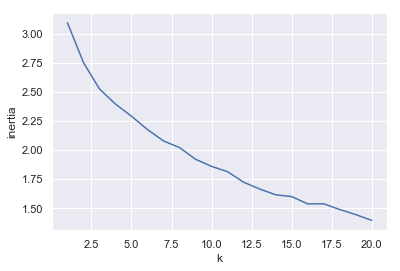

In [21]:
inertias = []
for i in range(1, 21):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(grouped_clustering)
    inertias.append(kmeans.inertia_)
sns.set()
sns.lineplot(x='k', y='inertia', data=pd.DataFrame({'k': range(1, 21), 'inertia': inertias}))

From the previoous plot, we see there is no clear "elbow", i.e. no clear turn in the tendency of the inertia line, so there is not a clear number of optimal clusters to use. Therefore we choose to use 8 clusters, and re-fit our model.

In [22]:
# set number of clusters
kclusters = 8

# run k-means clustering
kmeans = KMeans(n_clusters = kclusters, random_state=0).fit(grouped_clustering)

We add the cluster information as a new column to the dataframe.

In [23]:
grouped['Cluster'] = kmeans.labels_

And merge this with the geographical information for each city into a new datrame.

In [24]:
merged = grouped

merged = merged.join(df.set_index('City'), on='City')

We create again a world map including markers for all the cities, but this time color each marker using the associated cluster number, i.e. every element in each cluster is plotted using the same colour.

In [25]:
# create map
clusters_map = folium.Map(location=[center_lat, center_lon], zoom_start = 1.5)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(merged['Latitude'], merged['Longitude'], merged['City'], merged['Cluster']):
    txt = str(poi) + ' Cluster ' + str(cluster)
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius = 3,
        popup = folium.Popup(txt, parse_html=True),
        tooltip = txt,
        color = rainbow[int(cluster)-1],
        fill = True,
        fill_color = rainbow[int(cluster)-1],
        fill_opacity = 0.7).add_to(clusters_map)
       
clusters_map

We save the HTML map for further use.

In [26]:
clusters_map.save('clusters_map.html')

Inspect the number of cities in each cluster, by creating a bar plot of the number of cities in each cluster.

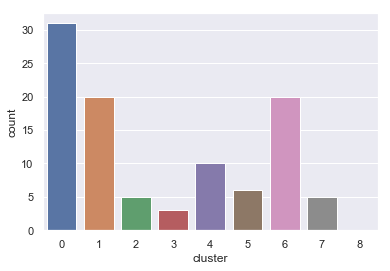

In [27]:
counts = []
for c in range(0, 9):
    counts.append(len(grouped[grouped['Cluster'] == c]))

sns.barplot(x="cluster", y="count", data=pd.DataFrame({'cluster': range(0,9), 'count': counts}))